# Holmusk Healthcare Data Challenge

The task is to analyze the clinical and financial data of patients hospitalized for a certain condition. Some variable names and patient_id's have been anonymized in this dataset. We are required to join the data given in different tables, and find insights about the drivers of cost of care.

## Problem Statement

In order to combat the issue of high hospitalisation bills, the Ministry of Health (MOH) wants to understand the drivers of cost of care for patients hospitalised for a certain condition.

## Executive Summary

In this project, we analysed various datasets and built a linear model to assess important predictors in determining a patient's cost of care. After processing and performing exploratory analysis of the data to gather insights, we used a Multiple Linear Regression (MLR) model to assess which features were the most important. Various recommendations were then provided for MOH to tackle the issue of high hospitalisation bills.

### Methodology

The methodology used during this project is as follows:
 
1. Data Exploration & Cleaning
- Datasets are cleaned & null imputation is performed
- Merge the data in 4 separate tables into 1 dataframe
- Adjust data to prepare for analysis
    
2. Feature Engineering
- Create new features to extract more useful information from our data

3. Exploratory Data Analysis 
- Visualise relationships between features and target variable (`bill_amount`)
- Perform feature selection for modelling

4. Modelling
- Create OLS model to predict target variable from group of features
- Analyse model coefficients

5. Conclusion
- Provide recommendations to MOH based on analysis
- Identify limitations of project


## Imports

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

In [2]:
# Changing default options for ease of analysis
pd.options.display.max_columns = 50

## Load Data

In [3]:
bill_amt = pd.read_csv('../data/bill_amount.csv')
bill_id = pd.read_csv('../data/bill_id.csv')
clinical = pd.read_csv('../data/clinical_data.csv')
demo = pd.read_csv('../data/demographics.csv')

## Data Exploration & Cleaning

There are 4 separate tables with different portions of the patients' clinical, financial and hospitalisation data. In this section we will check the data (data type, null values, duplicates) and determine the relationship between the tables before merging them for ease of analysis later on.

### Bill Amount

This dataframe consists of the bill ID and its corresponding amount in SGD.

In [4]:
bill_amt.head()

,bill_id,amount
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351
3,3818426276,755.965425
4,9833541918,897.347816


In [5]:
# Check for null values and dtypes
bill_amt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bill_id  13600 non-null  int64  
 1   amount   13600 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 212.6 KB


In [6]:
# No obvious outliers (improbable amounts for hospital stay)
bill_amt['amount'].describe()

count    13600.000000
mean      5464.767783
std       7717.479509
min         79.496707
25%        950.689008
50%       1516.951136
75%       7307.056573
max      81849.751340
Name: amount, dtype: float64

In [7]:
bill_amt.duplicated().any()

False

In [8]:
bill_amt[bill_amt['amount'].duplicated(keep=False)]

,bill_id,amount
2174,1935034703,1787.576169
4136,4051434449,30839.804020
5323,9017394852,20213.306482
6709,7917612349,13948.627998
8171,2964630827,1787.576169
12268,6723848537,13948.627998
12366,6463615675,30839.804020
12673,2367848755,1012.028954
12686,3180485821,1012.028954
12785,6618103440,20213.306482


There are no null values and the columns are of the correct data types. However, we notice that there are some duplicate amounts despite having different bill IDs. We will explore this later on when merged with the patient data.

In [9]:
# Renaming amount to bill_amount for clarity
bill_amt.columns = ['bill_id', 'bill_amount']

### Bill ID

This dataframe connects the bill ID to the patient ID and corresponding date of admission.

In [10]:
bill_id.head()

,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01


In [11]:
# Check for null values and dtypes
bill_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   bill_id            13600 non-null  int64 
 1   patient_id         13600 non-null  object
 2   date_of_admission  13600 non-null  object
dtypes: int64(1), object(2)
memory usage: 318.9+ KB


In [12]:
# Change date of admission to datetime format
bill_id['date_of_admission'] = pd.to_datetime(bill_id['date_of_admission'])

In [13]:
# No duplicates
bill_id.duplicated().any()

False

In [14]:
# Multiple entries for patient IDs
bill_id[bill_id['patient_id'].duplicated()]

,bill_id,patient_id,date_of_admission
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01
5,1692196063,1d21f2be18683991eb93d182d6b2d220,2011-01-01
6,784133534,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
...,...,...,...
13595,1641053864,a4c61deaa9ce86b4d2289eab6128b872,2015-12-28
13596,6956955826,ac52a32f8ce8c46d82df2d72052ae5a9,2015-12-28
13597,1399259594,4f67a54ab205cc9e7e2b0a4ee08e4fba,2015-12-28
13598,9243628699,a4c61deaa9ce86b4d2289eab6128b872,2015-12-28


In [15]:
# Number of unique patients
bill_id['patient_id'].nunique()

3000

In [16]:
bill_id[bill_id['patient_id'] == '1d21f2be18683991eb93d182d6b2d220']

,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01
5,1692196063,1d21f2be18683991eb93d182d6b2d220,2011-01-01
12792,6466235037,1d21f2be18683991eb93d182d6b2d220,2015-09-17
12793,7809633370,1d21f2be18683991eb93d182d6b2d220,2015-09-17
12794,5607272671,1d21f2be18683991eb93d182d6b2d220,2015-09-17
12795,5776306727,1d21f2be18683991eb93d182d6b2d220,2015-09-17


There are multiple bills for most patients, both within the same date of admission as well as across multiple dates. We will take note of this when merging dataframes later on.

### Clinical Data

This dataframe consists of the clinical data of the patients, including medical history, preop medications, symptoms, lab results and physical characteristics (height & weight).

In [17]:
clinical.head()

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0


In [18]:
# Check for null values and dtypes
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3400 non-null   object 
 1   date_of_admission   3400 non-null   object 
 2   date_of_discharge   3400 non-null   object 
 3   medical_history_1   3400 non-null   int64  
 4   medical_history_2   3167 non-null   float64
 5   medical_history_3   3400 non-null   object 
 6   medical_history_4   3400 non-null   int64  
 7   medical_history_5   3096 non-null   float64
 8   medical_history_6   3400 non-null   int64  
 9   medical_history_7   3400 non-null   int64  
 10  preop_medication_1  3400 non-null   int64  
 11  preop_medication_2  3400 non-null   int64  
 12  preop_medication_3  3400 non-null   int64  
 13  preop_medication_4  3400 non-null   int64  
 14  preop_medication_5  3400 non-null   int64  
 15  preop_medication_6  3400 non-null   int64  
 16  sympto

In [19]:
# Change date columns to datetime format
clinical['date_of_admission'] = pd.to_datetime(clinical['date_of_admission'])
clinical['date_of_discharge'] = pd.to_datetime(clinical['date_of_discharge'])

In [20]:
# medical_history_3 has object type
clinical['medical_history_3'].value_counts()

0      2176
No      761
1       348
Yes     115
Name: medical_history_3, dtype: int64

In [21]:
# Change to integer type
clinical['medical_history_3'] = clinical['medical_history_3'].map({'0': 0, 'No': 0, '1': 1, 'Yes': 1})

In [22]:
# medical_history_2 & medical_history_5 have null values
clinical['medical_history_2'].unique()

array([ 1.,  0., nan])

In [23]:
clinical['medical_history_5'].unique()

array([ 0., nan,  1.])

In [24]:
# Only values are 0 & 1, assume NaN means 0 as well
clinical['medical_history_2'] = clinical['medical_history_2'].fillna(0).astype(int)
clinical['medical_history_5'] = clinical['medical_history_5'].fillna(0).astype(int)

In [25]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  3400 non-null   object        
 1   date_of_admission   3400 non-null   datetime64[ns]
 2   date_of_discharge   3400 non-null   datetime64[ns]
 3   medical_history_1   3400 non-null   int64         
 4   medical_history_2   3400 non-null   int32         
 5   medical_history_3   3400 non-null   int64         
 6   medical_history_4   3400 non-null   int64         
 7   medical_history_5   3400 non-null   int32         
 8   medical_history_6   3400 non-null   int64         
 9   medical_history_7   3400 non-null   int64         
 10  preop_medication_1  3400 non-null   int64         
 11  preop_medication_2  3400 non-null   int64         
 12  preop_medication_3  3400 non-null   int64         
 13  preop_medication_4  3400 non-null   int64       

In [26]:
# Number of unique patients
clinical['id'].nunique()

3000

In [27]:
clinical[clinical['id'] == 'b2d15cda8c4e1f86ba43356434df6718']

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
88,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,2011-03-08,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0
273,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,2011-06-08,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0
986,b2d15cda8c4e1f86ba43356434df6718,2012-06-21,2012-06-29,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,17.0,28.3,125.0,77.3,151.0


There are multiple entries for some patients with multiple admissions as one row represents the clinical data for each individual admission. One interesting thing to note (as seen above with patient `b2d15cda8c4e1f86ba43356434df6718`) is that the medical history is not the same across multiple admissions for most patients. This could either be due to inconsistency in obtaining the information (e.g. different doctors asking different questions to assess the same particular column) or that the medical history of the patient did actually change between different hospital admissions.

In [28]:
# Rename for merging later on
clinical.rename(columns={'id': 'patient_id'}, inplace=True)

### Demographics

This dataframe consists of the demographic information of each patient.

In [29]:
demo.head()

,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15
4,541ad077cb4a0e64cc422673afe28aef,m,Chinese,Singaporean,1970-12-12


In [30]:
# Check for null values and dtypes
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       3000 non-null   object
 1   gender           3000 non-null   object
 2   race             3000 non-null   object
 3   resident_status  3000 non-null   object
 4   date_of_birth    3000 non-null   object
dtypes: object(5)
memory usage: 117.3+ KB


In [31]:
# Change date of birth to datetime type
demo['date_of_birth'] = pd.to_datetime(demo['date_of_birth'])

The `gender`, `race` and `resident_status` have inconsistent values, probably due to manual input. We will standardise them here.

In [32]:
demo['gender'].value_counts()

Female    1396
Male      1333
m          170
f          101
Name: gender, dtype: int64

In [33]:
demo['gender'] = demo['gender'].map({'m': 'Male', 'f': 'Female'}).fillna(demo['gender'])

In [34]:
demo['race'].value_counts()

Chinese    1608
Malay       629
chinese     307
Indian      195
Others      161
India       100
Name: race, dtype: int64

In [35]:
demo['race'] = demo['race'].map({'chinese': 'Chinese', 'India': 'Indian'}).fillna(demo['race'])

In [36]:
demo['resident_status'].value_counts()

Singaporean          1782
Singapore citizen     610
PR                    465
Foreigner             143
Name: resident_status, dtype: int64

In [37]:
demo['resident_status'] = demo['resident_status']\
    .map(lambda x: 'SC' if x == 'Singaporean' or x == 'Singapore citizen' else x)

In [38]:
demo['patient_id'].duplicated().any()

False

There are no duplicated entries, and the columns have been cleaned.

### Merging Dataframes

We will merge the separate dataframes into one for ease of analysis later on. First, we merge the bill amount with the bill ID.

In [39]:
bill = pd.merge(bill_id, bill_amt, on='bill_id')
bill.head()

,bill_id,patient_id,date_of_admission,bill_amount
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01,951.214467
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,19900.297086
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01,12338.269972
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,1145.372193
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01,1133.601902


In [40]:
bill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13600 entries, 0 to 13599
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   bill_id            13600 non-null  int64         
 1   patient_id         13600 non-null  object        
 2   date_of_admission  13600 non-null  datetime64[ns]
 3   bill_amount        13600 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 531.2+ KB


Next we left join the demographic data onto the clinical data since there are multiple rows for some patients in the `clinical` dataframe.

In [41]:
patient = pd.merge(clinical, demo, how='left', on='patient_id')
patient.head()

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SC,1976-12-19
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SC,1978-07-20
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,Female,Indian,SC,1967-08-14
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,Female,Chinese,PR,1967-12-06
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,Female,Others,PR,1982-07-18


In [42]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3400 entries, 0 to 3399
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          3400 non-null   object        
 1   date_of_admission   3400 non-null   datetime64[ns]
 2   date_of_discharge   3400 non-null   datetime64[ns]
 3   medical_history_1   3400 non-null   int64         
 4   medical_history_2   3400 non-null   int32         
 5   medical_history_3   3400 non-null   int64         
 6   medical_history_4   3400 non-null   int64         
 7   medical_history_5   3400 non-null   int32         
 8   medical_history_6   3400 non-null   int64         
 9   medical_history_7   3400 non-null   int64         
 10  preop_medication_1  3400 non-null   int64         
 11  preop_medication_2  3400 non-null   int64         
 12  preop_medication_3  3400 non-null   int64         
 13  preop_medication_4  3400 non-null   int64       

Finally, we left join the `patient` dataframe onto the `bill` dataframe on the `patient_id` and `date_of_admission` columns to obtain a single dataframe with all unique bill IDs and their corresponding patient data.

In [43]:
df = pd.merge(bill, patient, how='left', on=['patient_id', 'date_of_admission'])
df.head()

,bill_id,patient_id,date_of_admission,bill_amount,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01,951.214467,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SC,1976-12-19
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,19900.297086,2011-01-11,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SC,1978-07-20
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01,12338.269972,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SC,1976-12-19
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,1145.372193,2011-01-11,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SC,1978-07-20
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01,1133.601902,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SC,1976-12-19


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13600 entries, 0 to 13599
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bill_id             13600 non-null  int64         
 1   patient_id          13600 non-null  object        
 2   date_of_admission   13600 non-null  datetime64[ns]
 3   bill_amount         13600 non-null  float64       
 4   date_of_discharge   13600 non-null  datetime64[ns]
 5   medical_history_1   13600 non-null  int64         
 6   medical_history_2   13600 non-null  int32         
 7   medical_history_3   13600 non-null  int64         
 8   medical_history_4   13600 non-null  int64         
 9   medical_history_5   13600 non-null  int32         
 10  medical_history_6   13600 non-null  int64         
 11  medical_history_7   13600 non-null  int64         
 12  preop_medication_1  13600 non-null  int64         
 13  preop_medication_2  13600 non-null  int64     

In [45]:
# Checking to see that rows are unique to bill ID with correct patient information
df[df['patient_id'] == 'b2d15cda8c4e1f86ba43356434df6718']

,bill_id,patient_id,date_of_admission,bill_amount,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
366,1628284147,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,2182.823619,2011-03-08,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0,Female,Chinese,SC,1951-12-28
367,2895086851,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,1299.564847,2011-03-08,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0,Female,Chinese,SC,1951-12-28
368,8279583549,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,17805.982146,2011-03-08,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0,Female,Chinese,SC,1951-12-28
371,7551669547,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,1292.173179,2011-03-08,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0,Female,Chinese,SC,1951-12-28
1124,5940707534,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,936.469924,2011-06-08,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0,Female,Chinese,SC,1951-12-28
1126,6264238457,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,1307.990211,2011-06-08,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0,Female,Chinese,SC,1951-12-28
1127,3253341898,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,1277.956309,2011-06-08,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0,Female,Chinese,SC,1951-12-28
1128,4473085063,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,8140.565156,2011-06-08,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0,Female,Chinese,SC,1951-12-28
3972,7862839242,b2d15cda8c4e1f86ba43356434df6718,2012-06-21,1417.833296,2012-06-29,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,17.0,28.3,125.0,77.3,151.0,Female,Chinese,SC,1951-12-28
3975,6617689747,b2d15cda8c4e1f86ba43356434df6718,2012-06-21,1110.744978,2012-06-29,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,17.0,28.3,125.0,77.3,151.0,Female,Chinese,SC,1951-12-28


#### Duplicate Bill Amounts

Earlier, we noticed that there were some duplicate bill amounts (which is unlikely, given that the amounts are exact to 6 decimal places). We will take a deeper look at these entries in conjunction with the patient data.

In [46]:
df[df.bill_amount.duplicated(keep=False)].sort_values(by='bill_amount')

,bill_id,patient_id,date_of_admission,bill_amount,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
8820,2367848755,88daa1492f00862c8cdeb8ed181df22e,2014-04-03,1012.028954,2014-04-16,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,13.8,24.7,113.0,71.3,167.0,Male,Malay,SC,1968-02-26
10109,3180485821,88daa1492f00862c8cdeb8ed181df22e,2014-09-13,1012.028954,2014-09-30,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1,0,1,13.9,32.0,81.0,71.3,167.0,Male,Malay,SC,1968-02-26
12866,1935034703,1bd320d93143747b4c6f25e7f411fc5e,2015-10-01,1787.576169,2015-10-17,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,14.3,21.4,68.0,71.2,162.0,Female,Chinese,SC,1938-05-26
12871,2964630827,1bd320d93143747b4c6f25e7f411fc5e,2015-10-01,1787.576169,2015-10-17,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,14.3,21.4,68.0,71.2,162.0,Female,Chinese,SC,1938-05-26
4963,6723848537,58f4888c20f0e33426f6286178dd736c,2012-10-25,13948.627998,2012-11-08,0,0,0,1,0,0,1,0,1,1,1,1,0,0,1,0,1,1,13.4,24.9,118.0,78.3,157.0,Female,Chinese,SC,1973-01-23
9205,7917612349,a87be01440dac795b912f05b71912eac,2014-05-22,13948.627998,2014-06-01,0,1,0,0,0,0,0,1,0,1,1,1,1,0,1,0,1,1,13.3,28.8,75.0,78.3,157.0,Female,Chinese,SC,1974-11-23
10363,6618103440,51fa089fed7754cef2ca7fff0cd382d1,2014-10-20,20213.306482,2014-11-01,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,1,1,1,16.6,28.5,96.0,83.0,171.0,Male,Chinese,SC,1936-06-12
10984,9017394852,51fa089fed7754cef2ca7fff0cd382d1,2015-01-22,20213.306482,2015-02-01,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,13.8,27.1,80.0,83.0,171.0,Male,Chinese,SC,1936-06-12
9477,6463615675,753f03f5ebdf0fb5dd7974a3da083219,2014-06-16,30839.804020,2014-06-29,0,1,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,1,15.8,27.3,69.0,83.3,154.0,Female,Malay,SC,1963-06-15
10778,4051434449,753f03f5ebdf0fb5dd7974a3da083219,2014-12-20,30839.804020,2015-01-02,1,1,0,0,0,0,0,0,1,0,1,1,0,0,1,1,1,1,13.0,24.9,100.0,83.3,154.0,Female,Malay,SC,1963-06-15


As seen above, there are 5 incidences where the bill amount was duplicated. For 4 of these, they belong to the same patient, while the 5th duplicate bill belonged to two separate patient IDs which have the exact same demographic data (`weight`, `height`, `race` & `resident_status`). There were also 2 rows with the exact same data besides `bill_id` (Index `12866` & `12871`).

There could two possible reasons for the duplication:

1. The separate bill amounts were combined into one as they were for the same case
2. Human error while entering the data

However, the clinical data differed for the separate admissions, so it would be difficult to distribute the bill amount accurately for these rows. Thus, we will drop them from our dataframe (except for the exact duplicate).

In [47]:
# Drop rows with duplicated bill amounts
df = df.drop([8820, 10109, 12866, 4963, 9205, 10363, 10984, 9477, 10778]).reset_index(drop=True)

#### Adjusting Bill Amount for Inflation

As the dataset contains bills from 2011 to 2016, we will adjust the costs for inflation based on the [Consumer Price Index](https://data.gov.sg/dataset/consumer-price-index-monthly?resource_id=8910f829-5cd4-4425-9542-dc95320aafeb) (CPI) from the government's public data. We will adjust the bill amounts to the date of the latest date of discharge (January 2016) in order to get a fair comparison between datapoints from different time periods.

In [48]:
cpi_df = pd.read_csv('../data/cpi_2019.csv')
cpi_df.head()

,month,level_1,level_2,value
0,1961-01,All Items,Food,21.762
1,1961-01,All Items,Food Excl Food Serving Services,na
2,1961-01,All Items,Food Serving Services,na
3,1961-01,All Items,Clothing & Footwear,54.08
4,1961-01,All Items,Housing & Utilities,26.553


In [49]:
# Look at cpi for healthcare
cpi_df = cpi_df.loc[cpi_df['level_2'] == 'Health Care', ['month', 'value']].reset_index(drop=True)

In [50]:
# Fixing data types
cpi_df['month'] = pd.to_datetime(cpi_df['month']).dt.to_period('M')
cpi_df['value'] = pd.to_numeric(cpi_df['value'])

In [51]:
cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   month   720 non-null    period[M]
 1   value   720 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 11.4 KB


In [52]:
# Get base CPI from Jan 2016
base_cpi = float(cpi_df.loc[cpi_df['month'] == '2016-01', 'value'].values)
base_cpi

93.61

In [53]:
# Create function to adjust bill amount based on CPI (Jan 2016 as base)
def adjust_bill(x):
    month = x['date_of_discharge'].to_period('M')
    cpi = float(cpi_df.loc[cpi_df['month'] == month, 'value'].values)
    x['bill_amount'] = round(x['bill_amount'] * (base_cpi/cpi), 2)
    return x

In [54]:
df = df.apply(adjust_bill, axis=1)
df.head()

,bill_id,patient_id,date_of_admission,bill_amount,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01,1064.88,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SC,1976-12-19
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,22278.30,2011-01-11,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SC,1978-07-20
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01,13812.64,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SC,1976-12-19
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,1282.24,2011-01-11,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SC,1978-07-20
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01,1269.06,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SC,1976-12-19


#### Dropping Bill ID

The bill ID is unique to each observation and has no relation to the clinical and demographic data for each patient, thus we will be dropping this feature.

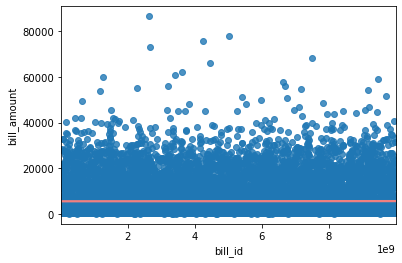

In [55]:
# Plot to confirm no discernible relationship between bill_id and amount
sns.regplot(data=df, x='bill_id', y='bill_amount', line_kws={'color':'lightcoral'});

In [56]:
df.drop(columns='bill_id', inplace=True)

#### Merging Bills from Same Hospitalisation

As mentioned earlier, we notice from the data is that there are multiple bills for the same patient for each hospitalisation occurrence. This is likely due to bills originating from multiple departments (e.g. ward, specialists, pharmacy, etc.) which had treated the patient during the same hospitalisation.

However, since we do not have enough information to identify which department each bill comes from, we will merge them together for each patient per hospitalisation to study the overall cost instead.

In [57]:
# Create dictionary of aggregate functions, only bill amount will be summed up
agg_funcs = {'bill_amount': 'sum'}
for col in df.drop(columns=['bill_amount', 'patient_id', 'date_of_discharge']).columns:
    agg_funcs[col] = 'first'
agg_funcs

{'bill_amount': 'sum',
 'date_of_admission': 'first',
 'medical_history_1': 'first',
 'medical_history_2': 'first',
 'medical_history_3': 'first',
 'medical_history_4': 'first',
 'medical_history_5': 'first',
 'medical_history_6': 'first',
 'medical_history_7': 'first',
 'preop_medication_1': 'first',
 'preop_medication_2': 'first',
 'preop_medication_3': 'first',
 'preop_medication_4': 'first',
 'preop_medication_5': 'first',
 'preop_medication_6': 'first',
 'symptom_1': 'first',
 'symptom_2': 'first',
 'symptom_3': 'first',
 'symptom_4': 'first',
 'symptom_5': 'first',
 'lab_result_1': 'first',
 'lab_result_2': 'first',
 'lab_result_3': 'first',
 'weight': 'first',
 'height': 'first',
 'gender': 'first',
 'race': 'first',
 'resident_status': 'first',
 'date_of_birth': 'first'}

In [58]:
# Apply aggregate functions to df grouped by each patient's unique hospitalisation occurrence
df_clean = df.groupby(['patient_id', 'date_of_discharge']).agg(agg_funcs)\
            .sort_values(by='date_of_discharge').reset_index()

**Before** (3 separate hospitalisations for same patient, 12 different bills - only difference between datapoints of the same hospitalisation is the bill amount)

In [59]:
df[df['patient_id']=='b2d15cda8c4e1f86ba43356434df6718']

,patient_id,date_of_admission,bill_amount,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
366,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,2444.80,2011-03-08,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0,Female,Chinese,SC,1951-12-28
367,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,1455.54,2011-03-08,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0,Female,Chinese,SC,1951-12-28
368,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,19943.02,2011-03-08,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0,Female,Chinese,SC,1951-12-28
371,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,1447.26,2011-03-08,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0,Female,Chinese,SC,1951-12-28
1124,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,1045.39,2011-06-08,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0,Female,Chinese,SC,1951-12-28
1126,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,1460.12,2011-06-08,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0,Female,Chinese,SC,1951-12-28
1127,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,1426.59,2011-06-08,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0,Female,Chinese,SC,1951-12-28
1128,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,9087.35,2011-06-08,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0,Female,Chinese,SC,1951-12-28
3972,b2d15cda8c4e1f86ba43356434df6718,2012-06-21,1516.63,2012-06-29,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,17.0,28.3,125.0,77.3,151.0,Female,Chinese,SC,1951-12-28
3975,b2d15cda8c4e1f86ba43356434df6718,2012-06-21,1188.14,2012-06-29,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,17.0,28.3,125.0,77.3,151.0,Female,Chinese,SC,1951-12-28


**After** (1 combined bill amount per patient per hospitalisation)

In [60]:
df_clean[df_clean['patient_id']=='b2d15cda8c4e1f86ba43356434df6718']

,patient_id,date_of_discharge,bill_amount,date_of_admission,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
90,b2d15cda8c4e1f86ba43356434df6718,2011-03-08,25290.62,2011-02-26,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,15.5,24.0,73.0,77.3,151.0,Female,Chinese,SC,1951-12-28
273,b2d15cda8c4e1f86ba43356434df6718,2011-06-08,13019.45,2011-06-02,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,14.3,25.8,125.0,78.3,151.0,Female,Chinese,SC,1951-12-28
986,b2d15cda8c4e1f86ba43356434df6718,2012-06-29,17679.52,2012-06-21,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,17.0,28.3,125.0,77.3,151.0,Female,Chinese,SC,1951-12-28


### Cleaned Dataframe

In [61]:
# Cleaned dataframe
display(df_clean.head())
df_clean.info()

,patient_id,date_of_discharge,bill_amount,date_of_admission,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
0,62bdca0b95d97e99e1c712048fb9fd09,2011-01-11,26087.61,2011-01-01,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SC,1978-07-20
1,1d21f2be18683991eb93d182d6b2d220,2011-01-11,17246.30,2011-01-01,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SC,1976-12-19
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-13,18822.23,2011-01-02,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,Female,Indian,SC,1967-08-14
3,e0397dd72caf4552c5babebd3d61736c,2011-01-14,31340.15,2011-01-02,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,Female,Chinese,PR,1967-12-06
4,94ade3cd5f66f4584902554dff170a29,2011-01-16,11987.50,2011-01-08,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,Female,Others,PR,1982-07-18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          3400 non-null   object        
 1   date_of_discharge   3400 non-null   datetime64[ns]
 2   bill_amount         3400 non-null   float64       
 3   date_of_admission   3400 non-null   datetime64[ns]
 4   medical_history_1   3400 non-null   int64         
 5   medical_history_2   3400 non-null   int64         
 6   medical_history_3   3400 non-null   int64         
 7   medical_history_4   3400 non-null   int64         
 8   medical_history_5   3400 non-null   int64         
 9   medical_history_6   3400 non-null   int64         
 10  medical_history_7   3400 non-null   int64         
 11  preop_medication_1  3400 non-null   int64         
 12  preop_medication_2  3400 non-null   int64         
 13  preop_medication_3  3400 non-null   int64       

In [62]:
# Save cleaned dataframe
df_clean.to_csv('../data/merged_clean.csv', index=False)

## Feature Engineering

We will be extracting more useful information from the dataset by transforming and combining some features from the original dataset.

### Length of Hospitalisation

Generally, we would expect that the bill amount would increase somewhat proportionately to the amount of time the patient spends in the hospital. We will be creating a new feature `days_in_hosp` to reflect this.

In [63]:
df_clean['days_in_hosp'] = (df_clean['date_of_discharge'] - df_clean['date_of_admission']).dt.days

### Patient Age

We can also take into account the patient's age in years at the point of admission as another feature to explore as the patient's `date_of_birth` does not tell us much by itself.

In [64]:
age = (df_clean['date_of_admission'] - df_clean['date_of_birth']).dt.days
df_clean['age_admitted'] = round(age/365, 1)

### Body Mass Index (BMI)

BMI is a measurement that has been used to estimate a person's risk for obesity-related diseases. It can be calculated by dividing the body mass (in kg) by the square of the body height (in metres). Although it has its [limitations](https://en.wikipedia.org/wiki/Body_mass_index#Limitations), it can still tell us more about a patient's physical characteristics.

In [65]:
df_clean['bmi'] = round(df_clean['weight'] / ((df_clean['height'] / 100) ** 2), 2)

### Year & Month of Hospitalisation

We can study if there are any trends for the month & year that the patient is hospitalised by extracting the information from `date_of_admission`

In [66]:
df_clean['year_admitted'] = df_clean['date_of_admission'].dt.year
df_clean['month_admitted'] = df_clean['date_of_admission'].dt.month

### Number of Times Hospitalised

Some patients were hospitalised multiple times over the time period. In order to study if repeated hospitalisations had an effect on the bill, we will create the `hosp_no` feature.

In [67]:
df_clean['hosp_no'] = df_clean.groupby('patient_id').cumcount() + 1

In [68]:
# Check to see increments are in order of date
df_clean.loc[df_clean['patient_id']=='b2d15cda8c4e1f86ba43356434df6718', 
             ['patient_id', 'date_of_admission', 'hosp_no']]

,patient_id,date_of_admission,hosp_no
90,b2d15cda8c4e1f86ba43356434df6718,2011-02-26,1
273,b2d15cda8c4e1f86ba43356434df6718,2011-06-02,2
986,b2d15cda8c4e1f86ba43356434df6718,2012-06-21,3


### Summed Clinical Features

We can also study if there is any relationship between the total number of clinical features (`medical_history`, `preop_medication`, `symptom`) for a patient's hospitalisation with the total bill amount by summing up their occurrences.

In [69]:
df_clean['total_med_hist'] = df_clean.iloc[:, 4:11].sum(axis=1)
df_clean['total_preop_meds'] = df_clean.iloc[:, 11:17].sum(axis=1)
df_clean['total_symptoms'] = df_clean.iloc[:, 17:22].sum(axis=1)

### Initial Feature Elimination

Now that we have conducted some feature engineering, we can proceed to drop certain features which are not useful for our analysis.

In [70]:
df_clean.drop(columns=['patient_id', 'date_of_discharge', 'date_of_admission', 'date_of_birth'], inplace=True)

In [71]:
# Cleaned dataframe
display(df_clean.head())
df_clean.info()

,bill_amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,days_in_hosp,age_admitted,bmi,year_admitted,month_admitted,hosp_no,total_med_hist,total_preop_meds,total_symptoms
0,26087.61,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SC,10,32.5,30.62,2011,1,1,0,4,3
1,17246.30,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SC,10,34.1,27.51,2011,1,1,1,3,2
2,18822.23,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,Female,Indian,SC,11,43.4,31.58,2011,1,1,0,5,4
3,31340.15,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,Female,Chinese,PR,12,43.1,27.87,2011,1,1,3,3,5
4,11987.50,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,Female,Others,PR,8,28.5,21.72,2011,1,1,2,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bill_amount         3400 non-null   float64
 1   medical_history_1   3400 non-null   int64  
 2   medical_history_2   3400 non-null   int64  
 3   medical_history_3   3400 non-null   int64  
 4   medical_history_4   3400 non-null   int64  
 5   medical_history_5   3400 non-null   int64  
 6   medical_history_6   3400 non-null   int64  
 7   medical_history_7   3400 non-null   int64  
 8   preop_medication_1  3400 non-null   int64  
 9   preop_medication_2  3400 non-null   int64  
 10  preop_medication_3  3400 non-null   int64  
 11  preop_medication_4  3400 non-null   int64  
 12  preop_medication_5  3400 non-null   int64  
 13  preop_medication_6  3400 non-null   int64  
 14  symptom_1           3400 non-null   int64  
 15  symptom_2           3400 non-null   int64  
 16  sympto

In [72]:
# Save cleaned dataframe
df_clean.to_csv('../data/clean_FE.csv', index=False)

## EDA

We can visualise the features in the cleaned data to gather some insights, which will help in our analysis & evaluation later on. We will also be doing some feature elimination where relevant by assessing the features' relationship with the `bill_amount`.

### Categorical Features

We will see the boxplot & bar chart for categorical features to visualise underlying distributions. We are looking to see how useful (or not useful) the feature would be in predicting the bill amount, as well as gathering insights based on their distributions.

In [73]:
# Creating a function to show a boxplot and barplot for each feature side by side
def plot_cat(dataframe, list_of_features, figsize=()):
    nrows = len(list_of_features) # 1 row per feature, 2 plots per feature
    fsize = (14, len(list_of_features) * 5)
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=fsize, sharex=False, sharey=False)
    ax = ax.ravel()
    
    for i, feature in enumerate(list_of_features):
        # boxplot on the left
        sns.boxplot(
            ax=ax[i*2],
            data=dataframe,
            x=feature,
            y='bill_amount',
            orient='v',
            linewidth=1,
            palette='viridis'
        )
        
        # bar chart on the right
        sns.countplot(
            data=dataframe,
            x=feature,
            ax=ax[(i*2 + 1)],
            palette='viridis',
            dodge=False
            )
        
        ax[i*2].set_xlabel(feature, fontsize=14, fontweight='bold')
        ax[(i*2) + 1].set_xlabel(feature, fontsize=14, fontweight='bold')
        
    fig.tight_layout()

#### Medical History

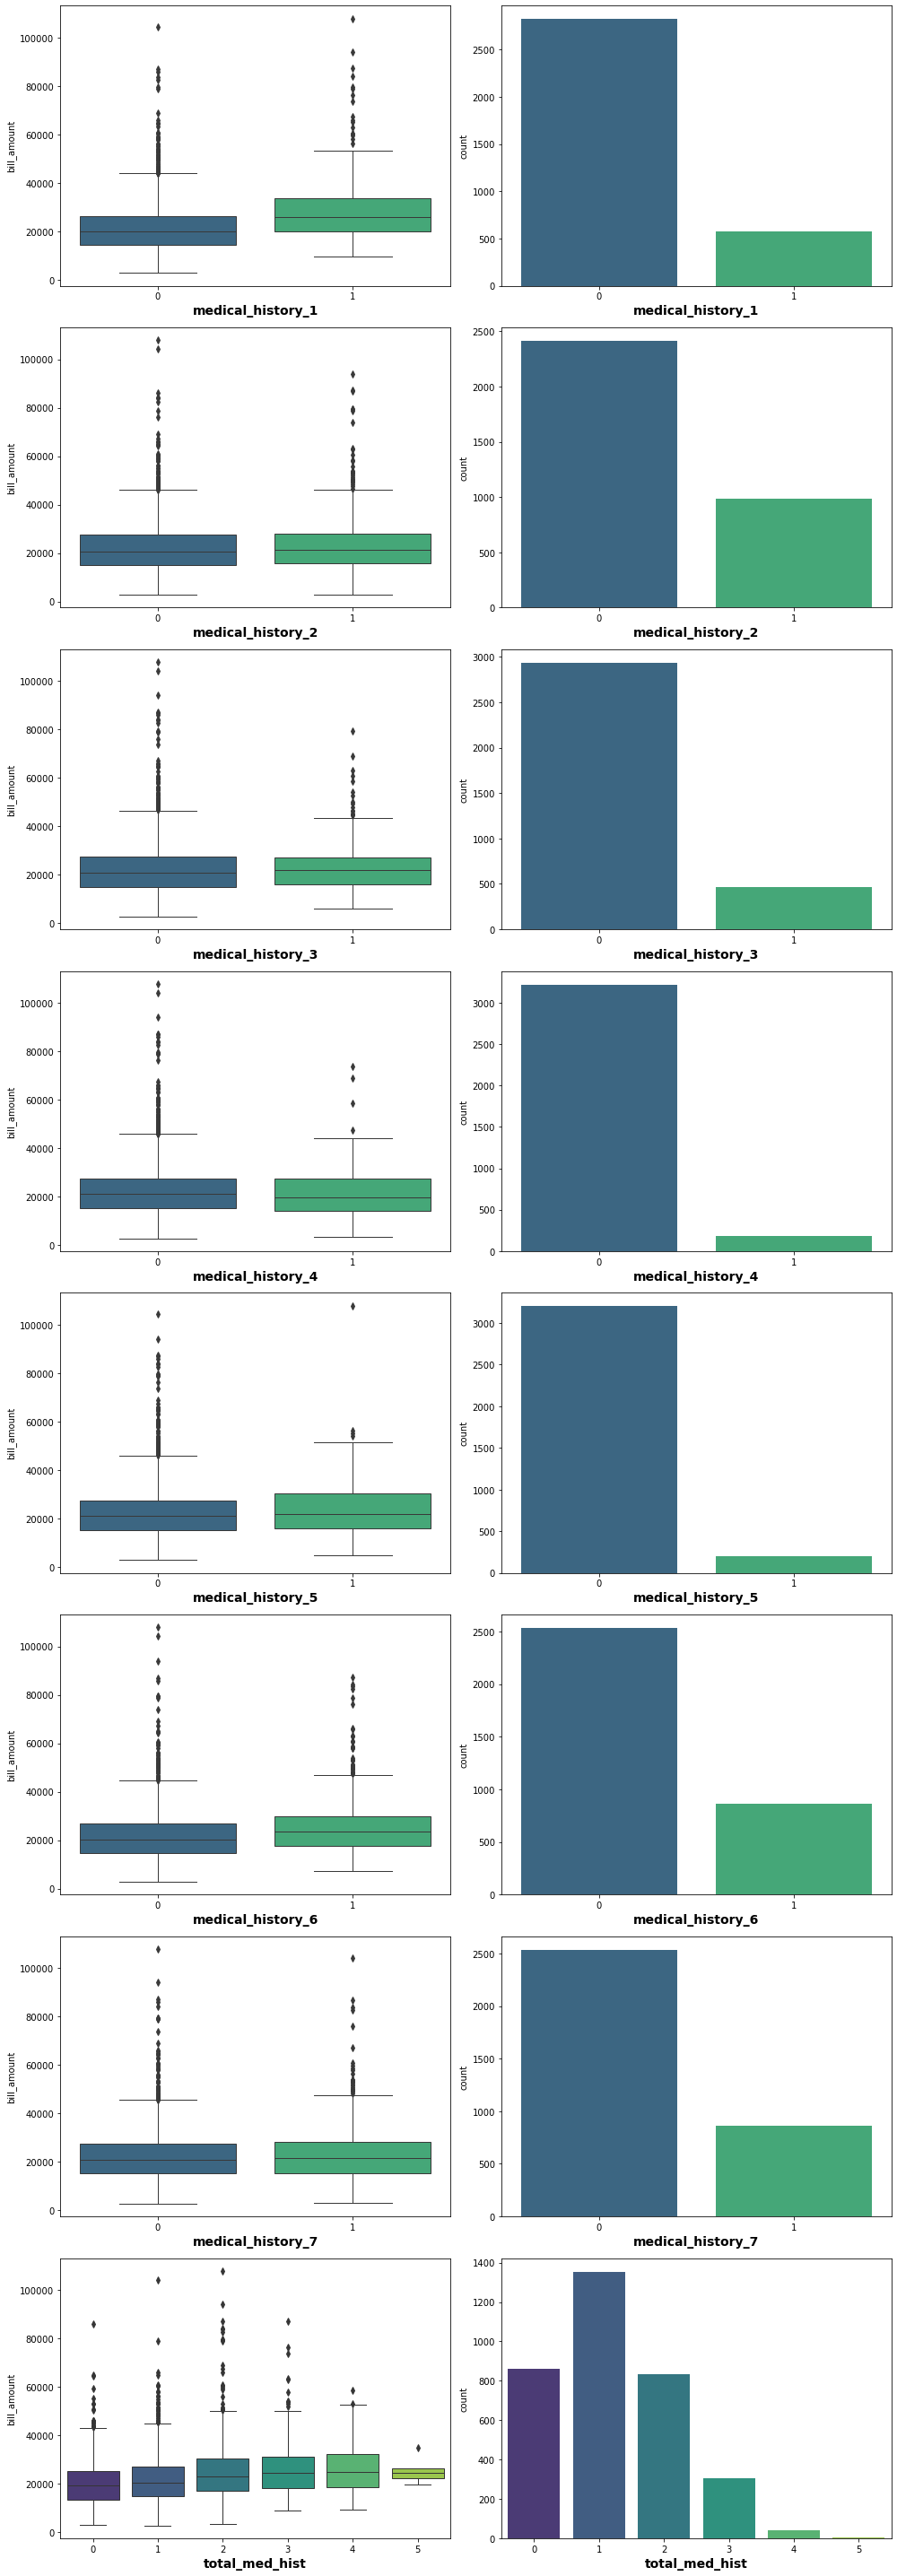

In [74]:
med_hist = ['medical_history_1', 'medical_history_2', 'medical_history_3', 'medical_history_4', 
            'medical_history_5', 'medical_history_6', 'medical_history_7', 'total_med_hist']
plot_cat(df_clean, med_hist)

- For each individual medical history, most patients do not have it
- Except for `medical_history_4`, the median bill amount for patients with each individual medical history is higher than for those without (but the differences are quite small)
- `medical_history_1` has the largest difference in medians between patients with/without the history, indicating that the presence of this feature could be an important driver in the final bill amount
- There seems to be a positive trend for `total_med_hist`, indicating that patients with multiple preexisting conditions tend to end up with higher bill amounts. We will treat this as an ordinal variable
- There is a right skew in the distribution for `total_med_hist`. Most patients had little medical histories (0 - 2), with a decreasing trend for higher `total_med_hist`. This is probably due to the fact that the medical histories examined here are not very dependent of each other and this it would be unlikely for a patient to have 3 or more

#### Preop Medication

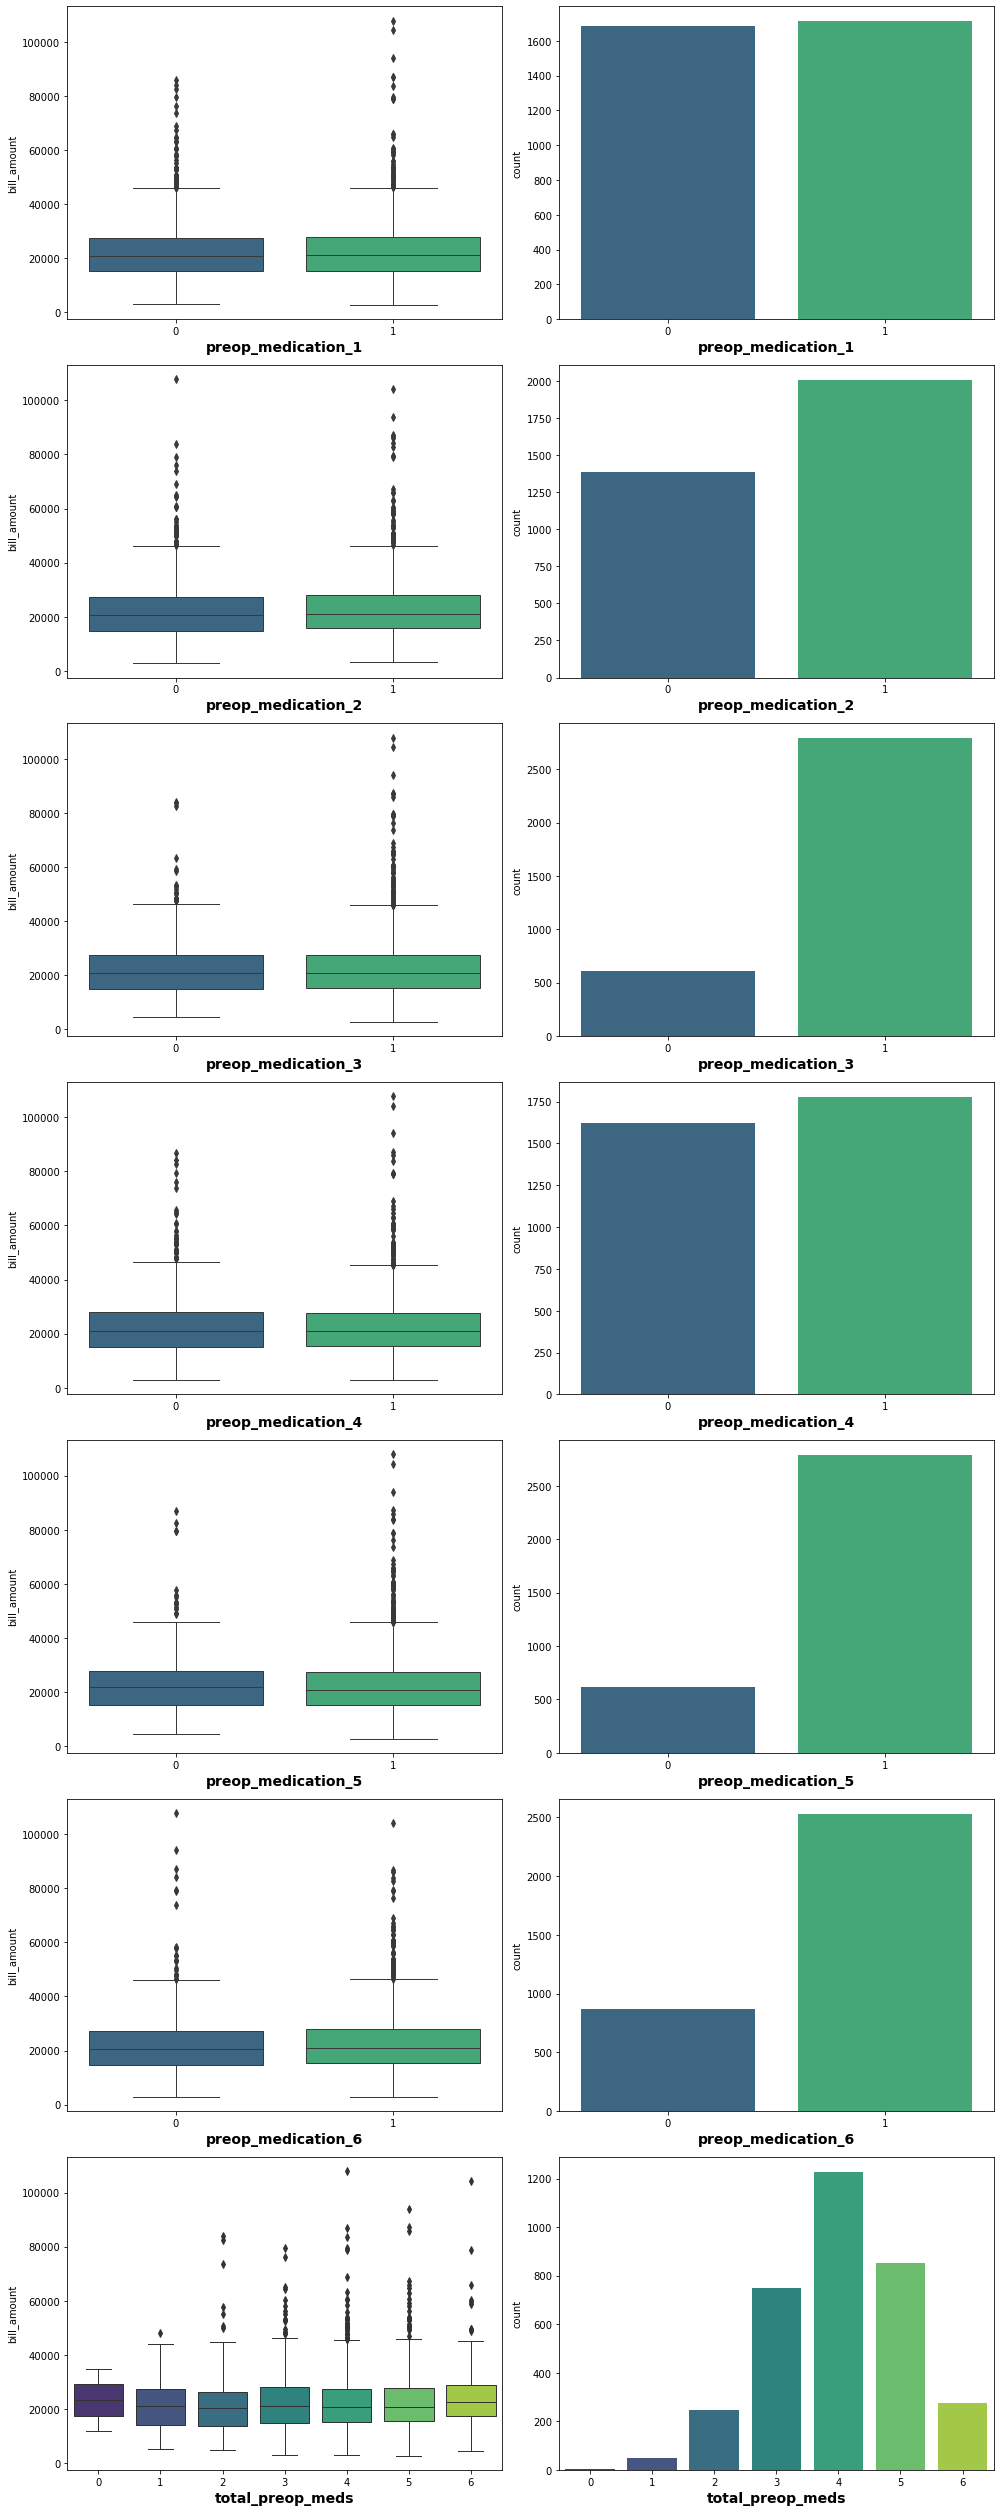

In [75]:
preop_meds = ['preop_medication_1', 'preop_medication_2', 'preop_medication_3', 'preop_medication_4', 
            'preop_medication_5', 'preop_medication_6', 'total_preop_meds']
plot_cat(df_clean, preop_meds)

- Except for `preop_medication_1`, most patients were given each individual preop medication
- There is a left skew for `total_preop_meds`. Most patients received 3 - 5 different preop meds (out of 6). The patients who received very few preop meds might have certain allergies or preexisting conditions and therefore are in the minority
- There is almost no difference in medians for each individual preop_medication, which indicates that this might not be such an important feature for predicting bill amounts
- There is no clear trend for `total_preop_meds` either
    - It appears that patients given no preop medications have higher median bill amounts, but there are only two observations for this category so the data might be highly variable
- We will drop this feature for the modelling

#### Symptoms

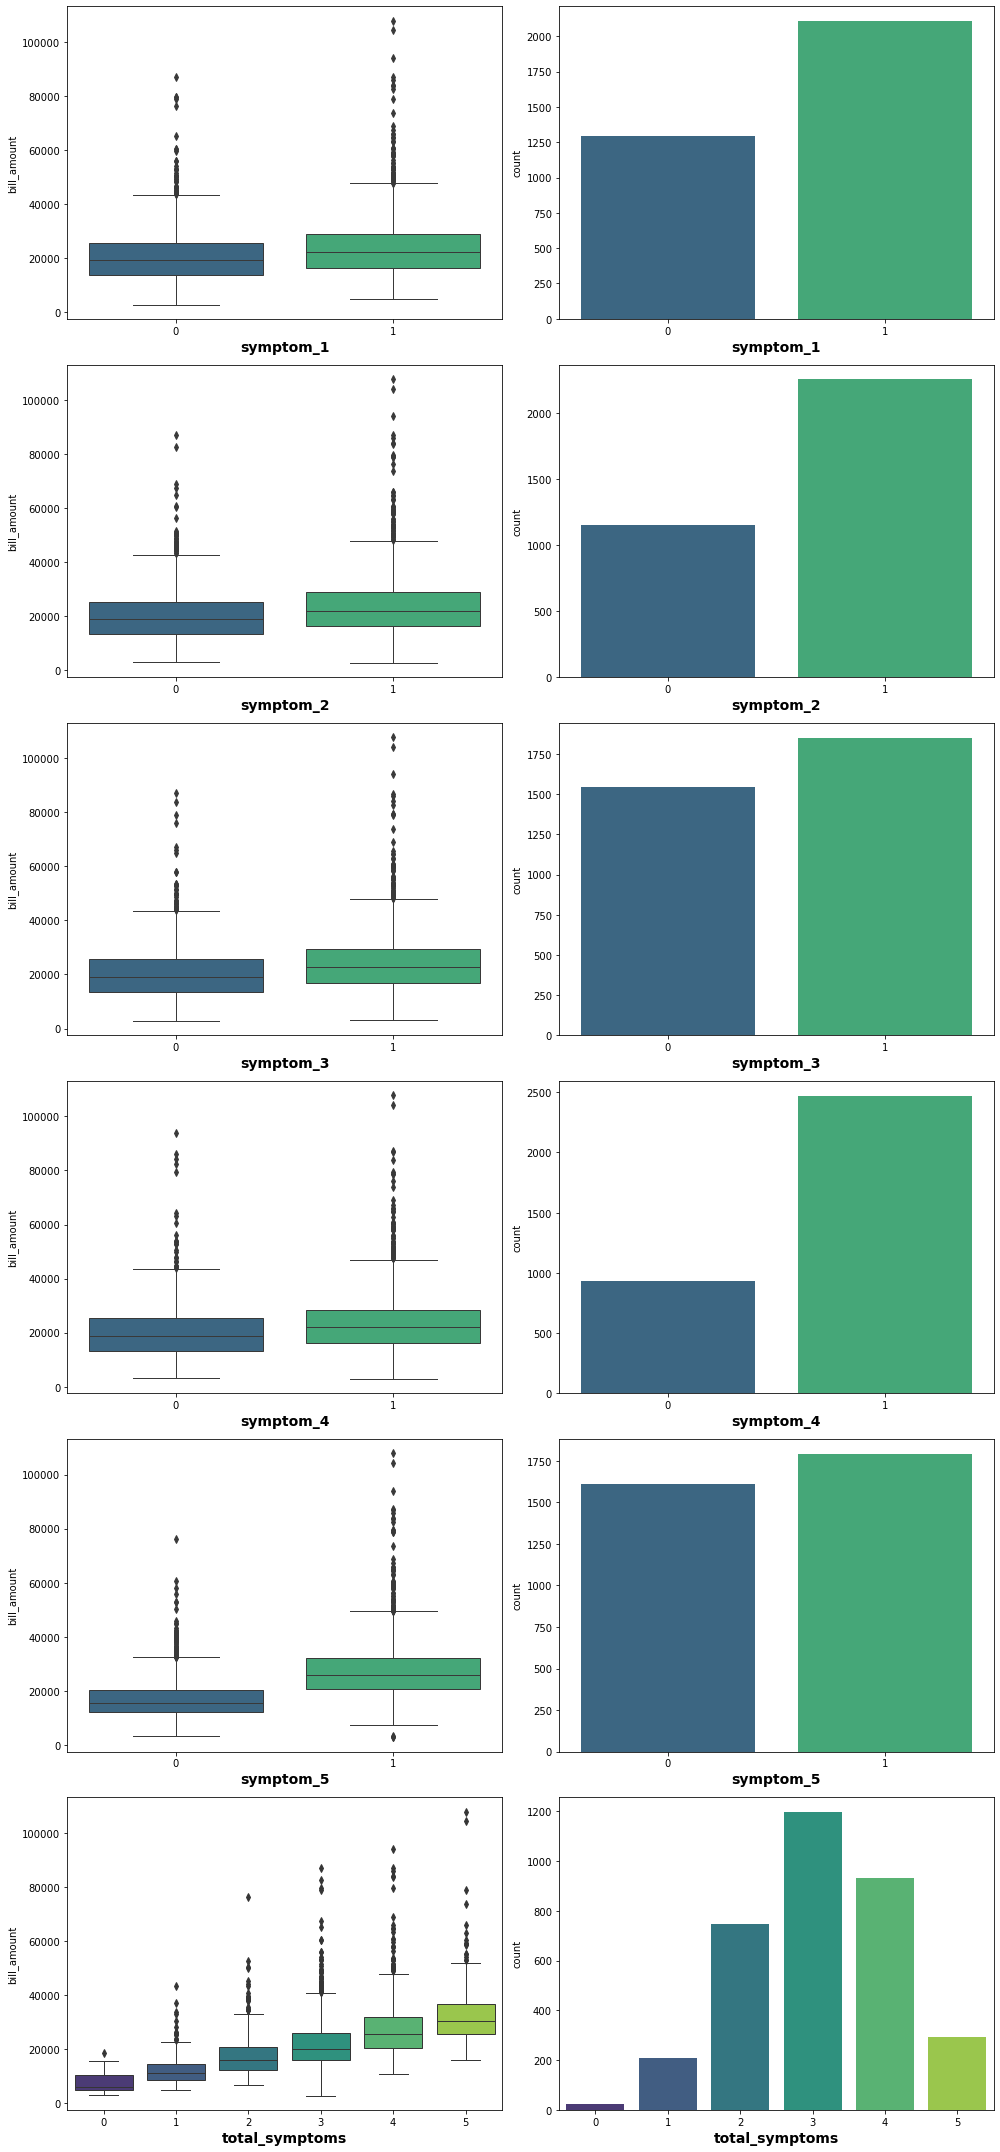

In [76]:
symptoms = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'total_symptoms']
plot_cat(df_clean, symptoms)

- For each individual symptom, more patients have the symptom than not. The median bill amount is also higher for patients who have the symptom for each individual symptom
- There is a slight left skew for `total_symptoms`, with most patients having 2 - 4 symptoms (out of 5). There are fewer patients with 0 or 1 symptoms, this is probably because patients with fewer symptoms do not end up being hospitalised and are not represented in this dataset
- There is a clear positive trend in the median bill amounts for `total_symptoms`. This is probably due to the fact that patients with more symptoms require more care and medication to combat the symptoms. We will treat this as an ordinal variable

#### Demographic Data

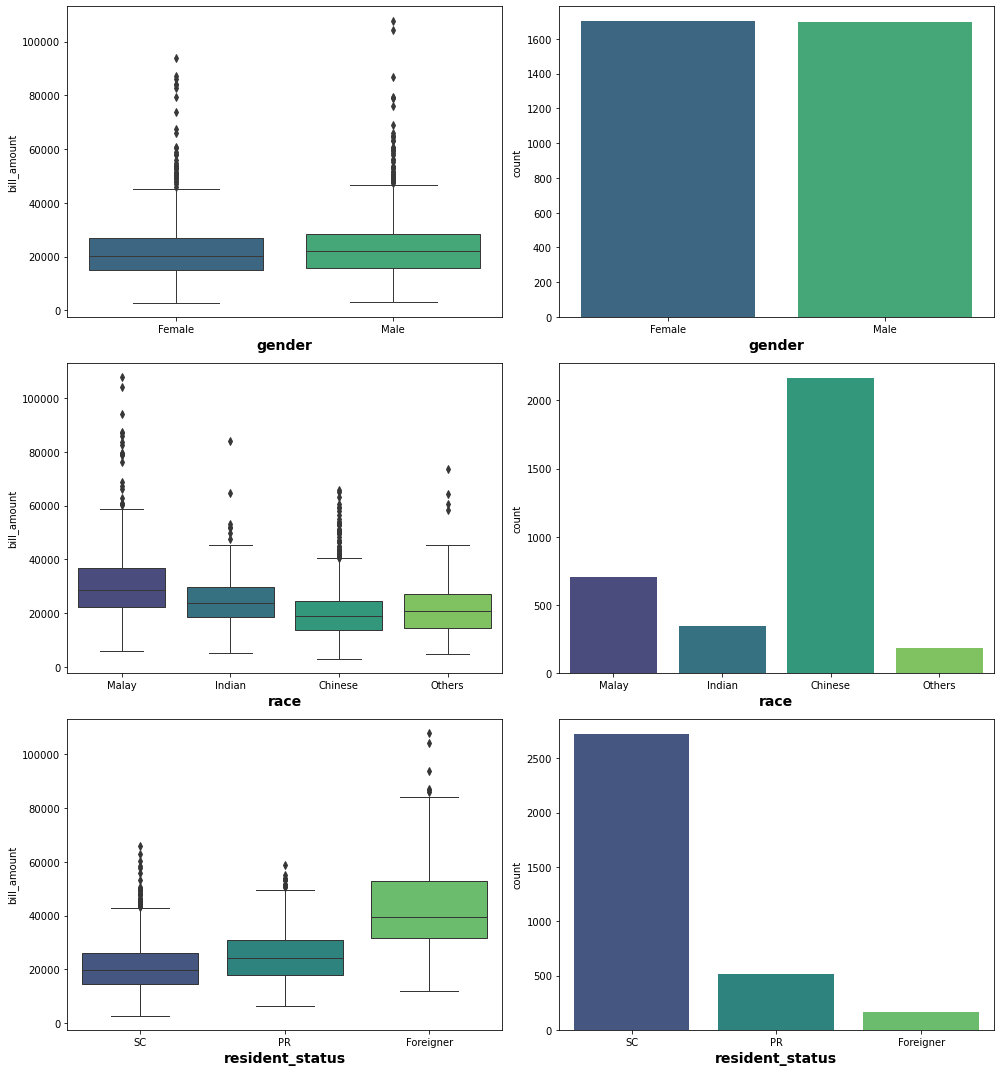

In [77]:
demo = ['gender', 'race', 'resident_status']
plot_cat(df_clean, demo)

There is a quite even balance in the `gender` column, indicating that this condition is not gender-biased such as breast cancer. However, it could just be a result of the method of extracting the data so this is not conclusive. Male patients have a slightly higher median bill amount than female patients.

The `race` statistics generally line up with the [2020 Census of Population](https://www.singstat.gov.sg/-/media/files/visualising_data/infographics/c2020/c2020-population.pdf), although the minority races are slightly overrepresented in the dataset. One interesting thing to note is that Malay patients have the highest median bill amount, followed by Indian, Others and Chinese having the lowest. There have been [studies conducted](https://bmcpublichealth.biomedcentral.com/articles/10.1186/1471-2458-13-1012) to explore the underlying causes of these race-specific differences, however that is not the main focus of our study and we will just treat it as another feature in the dataset.

The `resident_status` is quite skewed towards Singapore Citizens & Permanent Residents, with foreigners being underrepresented in the dataset. This likely indicates that the dataset is from public hospitals, as Singapore Citizens & PRs benefit from greater subsidies there. The median bill amounts for each category also reflect this pattern, with foreigners having the highest median bill amount, followed by PRs and SCs.

We will treat these features as nominal.

#### Hospitalisation Length & Number

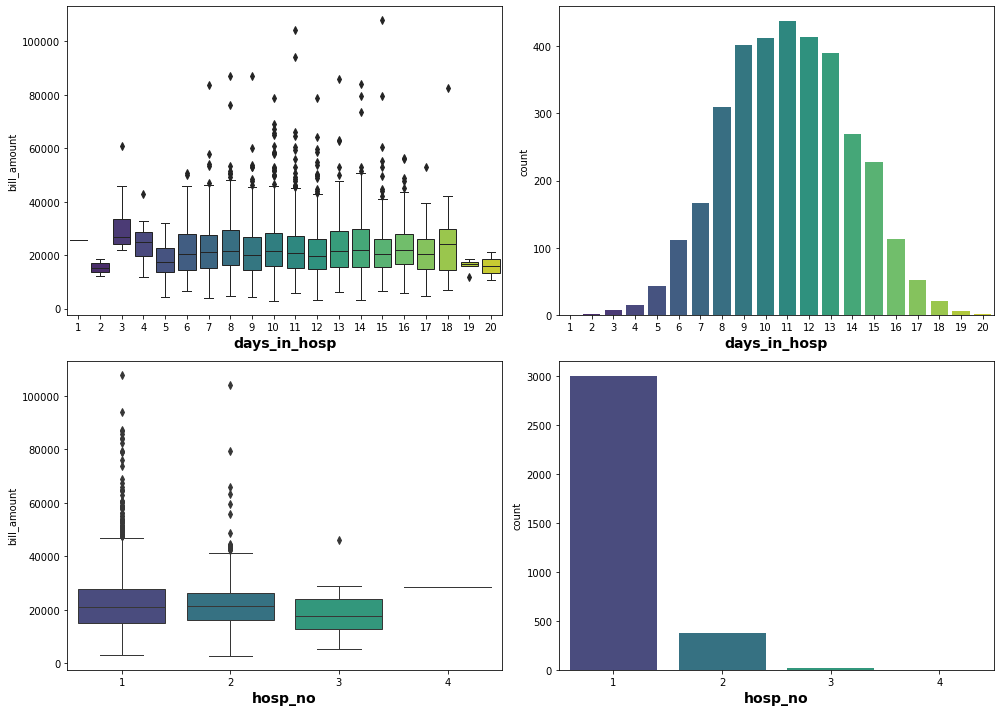

In [78]:
hosp = ['days_in_hosp', 'hosp_no']
plot_cat(df_clean, hosp)

The `days_in_hosp` has an approximately normal distribution, with a mean of around 11 days. However, there is no clear relationship between the number of days the patient is hospitalised and the median bill amount. This actually runs contrary to expectations and indicates that the portions of the bill related to length of stay (e.g. room charges, daily treatment fees, etc.) do not make up a large proportion of the total bill amount.

Similarly, there is no clear trend in median bill amounts for `hosp_no` as well. Most data points were from the patient's first hospitalisation, followed by second and very few from their 3rd & 4th. However, this feature was created using data beginning in Jan 2011, so it may not be very accurate for patients for patients who may have been hospitalised before that.

Thus, we will be dropping these two features as they will not be very useful for our model later on.

#### Year/Month of Hospitalisation

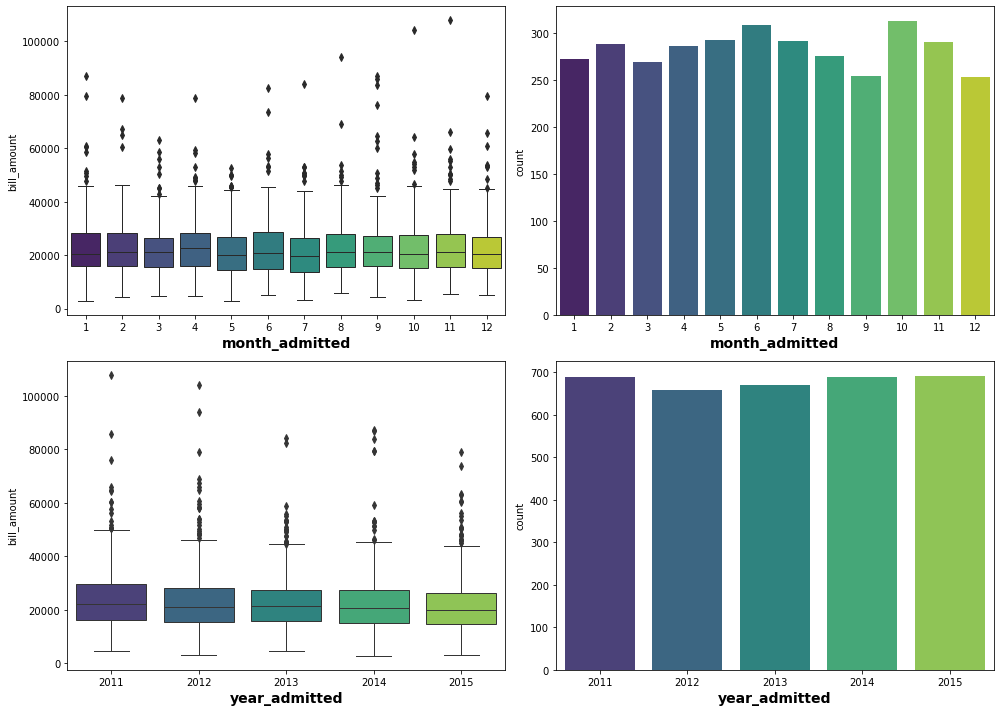

In [79]:
plot_cat(df_clean, ['month_admitted', 'year_admitted'])

- The distribution of data points across the years and months are quite balanced
- There is no clear relationship between the `month_admitted` and the bill amount
- There seems to be a slight downward trend in the median bill amounts for `year_admitted`, indicating that the total bill amounts seem to be dropping year-on-year
    - This could be due to the adjustment for `CPI` done earlier, as bill amounts from earlier years were adjusted with a slight increase
    - This feature is not very useful in understanding the problem statement as it simply shows a year-on-year trend instead of helping to understand a possible driver in the cost of care for the patients
- Thus, we will drop these features

### Continuous Features

We can explore continuous features with pairplots against `bill_amount`.

In [80]:
# Creating a function to show scatter plots of feature against bill amount
def plot_cont(dataframe, list_of_features, figsize=()):
    nrows = int(np.ceil(len(list_of_features)/2))
    fsize = (14, nrows * 5)
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=fsize, sharex=False, sharey=True)
    ax = ax.ravel()
    
    for i, feature in enumerate(list_of_features):      
        sns.regplot(
            data=dataframe,
            x=feature, 
            y='bill_amount', 
            ax=ax[i],
            scatter_kws={'s': 4, 'alpha': 0.5},
            line_kws={'color':'lightcoral'}
        )

        ax[i].set_xlabel(feature, fontsize=14, fontweight='bold')
        
    if len(list_of_features) % 2 != 0: # remove last subplot for odd-numbered list of features
        ax[-1].set_axis_off()
         
    fig.tight_layout()

#### Lab Results

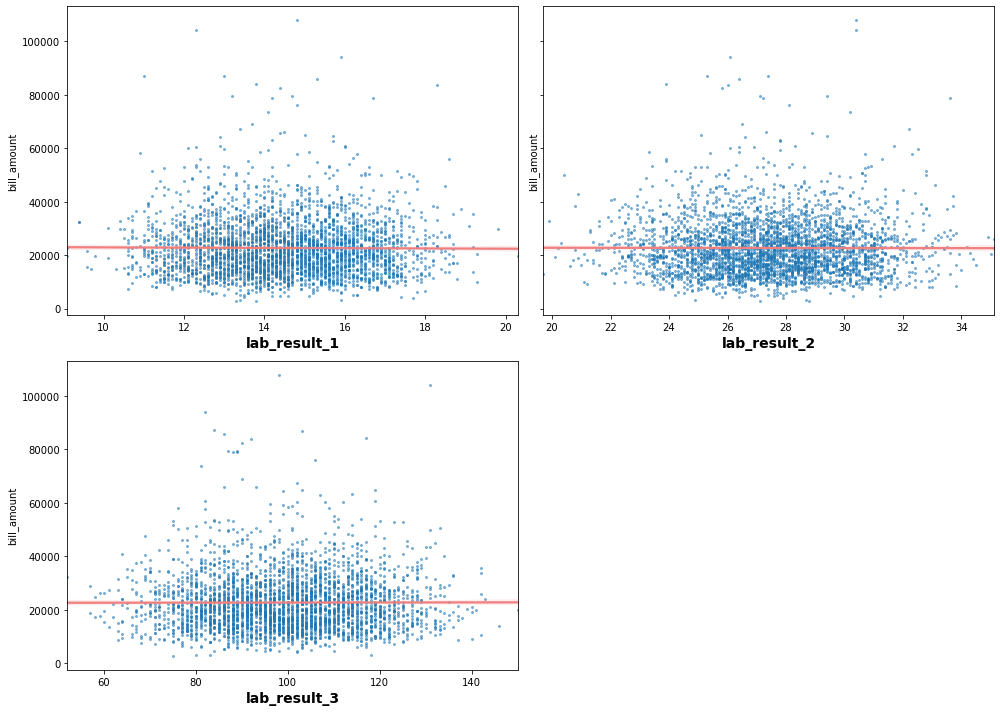

In [81]:
lab_res = ['lab_result_1', 'lab_result_2', 'lab_result_3']
plot_cont(df_clean, lab_res)

There seems to be no clear relationship between each `lab_result` and the `bill_amount`. This is probably due to the fact that the patient would be charged the same amount for the lab test regardless of the result. While these results may be useful for the doctor to decide certain treatments, it is not useful in determining the bill amount and thus we will drop these features.

#### Physical Characteristics

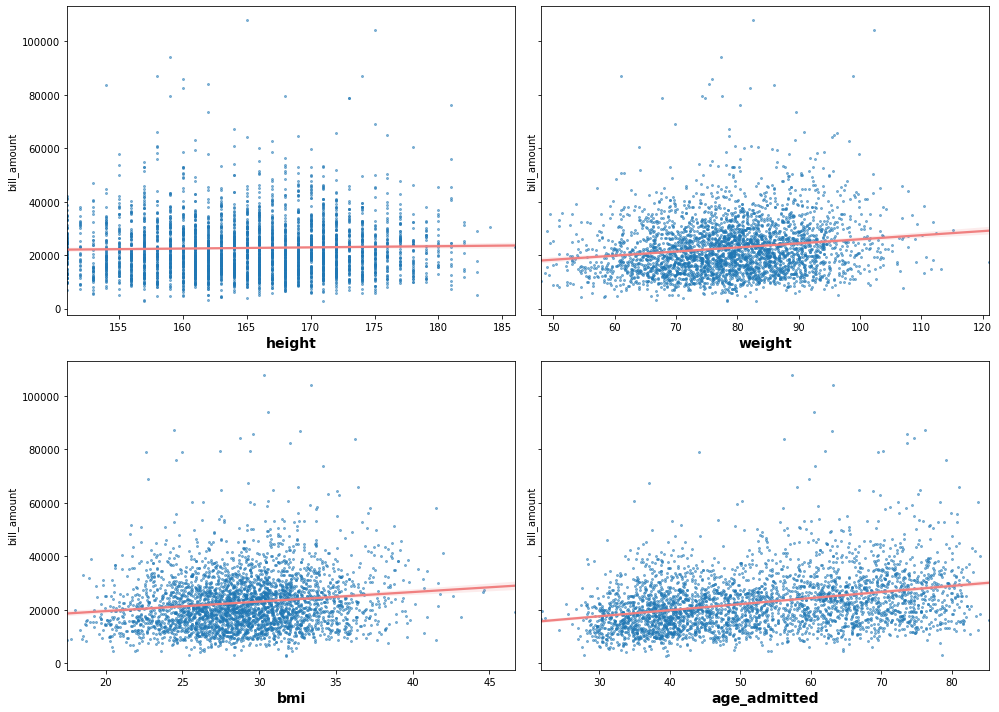

In [82]:
phys = ['height', 'weight', 'bmi', 'age_admitted']
plot_cont(df_clean, phys)

- No clear correlation between `height` and `bill_amount`, we will drop this feature
- Slight positive correlation for `weight`, `bmi` and `age_admitted` against `bill_amount`
    - Older, heavier patients tend to end up with higher bill amounts

One thing to note for BMI is that [low BMIs (<18.5) are also considered 'unhealthy'](https://www.healthhub.sg/live-healthy/410/Healthy%20Weight). However, within this range, there are few observations in our dataset and there is no negative correlation either. This indicates that the bill amount is more affected by obesity as compared to underweight patients.

### Feature Elimination

As discussed above, we will be dropping the features that do not have a meaningful relationship with the bill amount, and thus will not be useful for our model later on.

In [83]:
features_to_drop = [
    'preop_medication_1',
    'preop_medication_2',
    'preop_medication_3', 
    'preop_medication_4', 
    'preop_medication_5', 
    'preop_medication_6',
    'total_preop_meds',
    'days_in_hosp',
    'hosp_no',
    'year_admitted',
    'month_admitted',
    'lab_result_1', 
    'lab_result_2', 
    'lab_result_3',
    'height'
]

In [84]:
df_clean.drop(columns=features_to_drop, inplace=True)

In [85]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_amount        3400 non-null   float64
 1   medical_history_1  3400 non-null   int64  
 2   medical_history_2  3400 non-null   int64  
 3   medical_history_3  3400 non-null   int64  
 4   medical_history_4  3400 non-null   int64  
 5   medical_history_5  3400 non-null   int64  
 6   medical_history_6  3400 non-null   int64  
 7   medical_history_7  3400 non-null   int64  
 8   symptom_1          3400 non-null   int64  
 9   symptom_2          3400 non-null   int64  
 10  symptom_3          3400 non-null   int64  
 11  symptom_4          3400 non-null   int64  
 12  symptom_5          3400 non-null   int64  
 13  weight             3400 non-null   float64
 14  gender             3400 non-null   object 
 15  race               3400 non-null   object 
 16  resident_status    3400 

#### Heatmap

We can also examine the heatmap of our numeric features to look out for evidence of multicollinearity, which will reduce the model's performance due to overfitting.

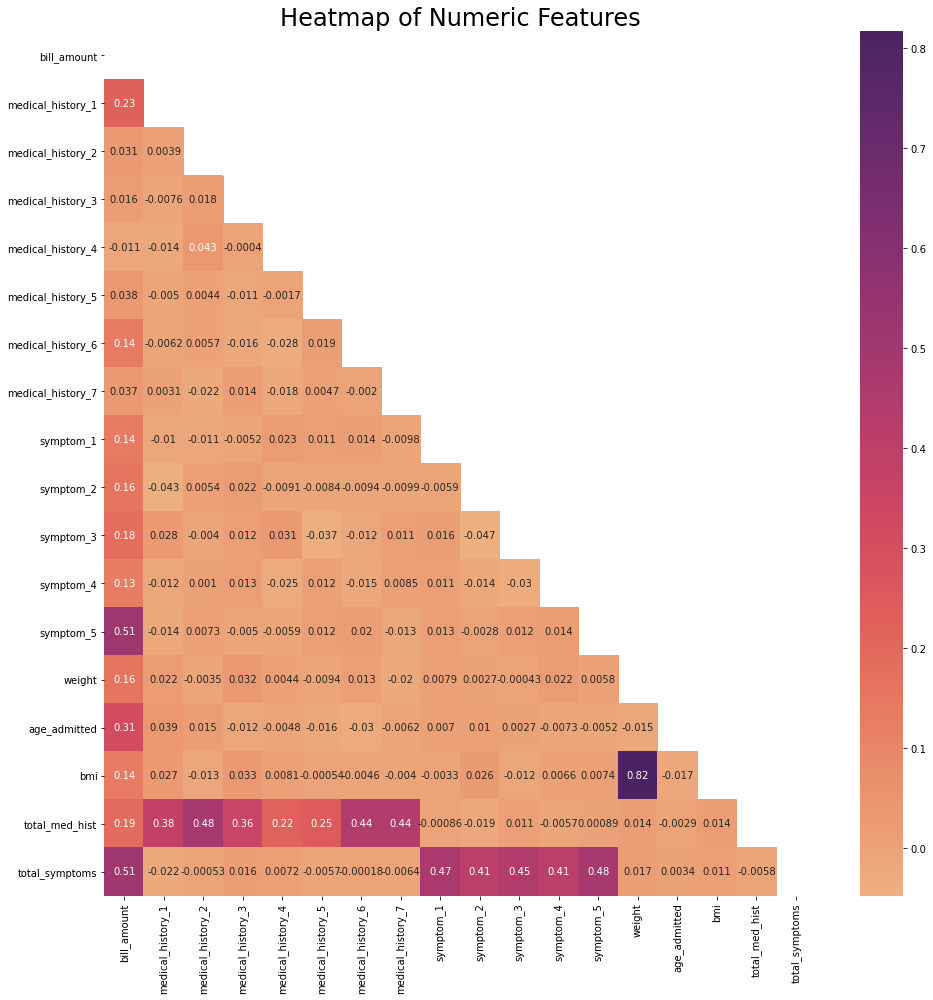

In [86]:
cols = df_clean.drop(columns=['gender', 'race', 'resident_status']).columns
fig, ax = plt.subplots(figsize=(14,14))

# Generate a mask for the upper triangle
mask = np.zeros_like(df_clean[cols].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    data=df_clean[cols].corr(),
    mask=mask,
    ax=ax,
    annot=True,
    cmap='flare'
) 

ax.set_title('Heatmap of Numeric Features', fontsize=24)
fig.tight_layout()

There is an obviously high correlation between `weight` and `bmi` as they are mathematically related to each other. However, we observe that `weight` has a higher correlation with the target variable than `bmi`, so we will be dropping `bmi`.

`total_symptoms` and `total_med_hist` have moderate correlations with their individual components. However, they have relatively strong correlation with the target variable as well. We will keep these features.

#### Final Feature Set for Modelling

In [87]:
final_df = df_clean.drop(columns='bmi')

In [88]:
# Final cleaned dataframe
display(final_df.head())
final_df.info()

,bill_amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,weight,gender,race,resident_status,age_admitted,total_med_hist,total_symptoms
0,26087.61,0,0,0,0,0,0,0,0,0,1,1,1,78.4,Female,Malay,SC,32.5,0,3
1,17246.30,0,1,0,0,0,0,0,0,0,0,1,1,71.3,Male,Indian,SC,34.1,1,2
2,18822.23,0,0,0,0,0,0,0,1,1,1,1,0,72.0,Female,Indian,SC,43.4,0,4
3,31340.15,0,1,0,0,0,1,1,1,1,1,1,1,64.4,Female,Chinese,PR,43.1,3,5
4,11987.50,0,0,0,0,0,1,1,0,1,0,1,0,55.6,Female,Others,PR,28.5,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_amount        3400 non-null   float64
 1   medical_history_1  3400 non-null   int64  
 2   medical_history_2  3400 non-null   int64  
 3   medical_history_3  3400 non-null   int64  
 4   medical_history_4  3400 non-null   int64  
 5   medical_history_5  3400 non-null   int64  
 6   medical_history_6  3400 non-null   int64  
 7   medical_history_7  3400 non-null   int64  
 8   symptom_1          3400 non-null   int64  
 9   symptom_2          3400 non-null   int64  
 10  symptom_3          3400 non-null   int64  
 11  symptom_4          3400 non-null   int64  
 12  symptom_5          3400 non-null   int64  
 13  weight             3400 non-null   float64
 14  gender             3400 non-null   object 
 15  race               3400 non-null   object 
 16  resident_status    3400 

In [89]:
# Save final dataframe
final_df.to_csv('../data/final_df.csv', index=False)

## Modelling

Now that all the exploratory data analysis & cleaning is done, we can start building our model. We will be using the statsmodels API (OLS - Multiple Linear Regression) to assess the predictors/features of our dataset. We do not need to one-hot encode or scale our data as the statsmodel API provides functions to identify categorical variables and we will not be including any regularisation in our analysis.

### OLS Model

In [90]:
# Creating formula for OLS model, C indicates categorical variable
formula = 'bill_amount ~ C(medical_history_1) + C(medical_history_2) + C(medical_history_3) + \
            C(medical_history_4) + C(medical_history_5) + C(medical_history_6) + \
            C(medical_history_7) + total_med_hist + C(symptom_1) + C(symptom_2) + \
            C(symptom_3) + C(symptom_4) + C(symptom_5) + total_symptoms + weight + \
            C(gender) + C(race) + C(resident_status) + age_admitted'

In [91]:
model = smf.ols(formula=formula, data=final_df)

In [92]:
res = model.fit()

#### Analysing Predictions

In [93]:
preds = res.predict(final_df.drop(columns='bill_amount'))
residuals = final_df['bill_amount'] - preds

In [94]:
mean_squared_error(final_df['bill_amount'], preds, squared=False)

3180.92288580268

In [95]:
# Create function to show predictions & residuals
def plot_results(y, y_preds, y_residuals, origin=0):
    fig, ax = plt.subplots(1, 2, figsize=(14,7))
    
    # Generate a scatterplot of predicted values versus actual values.
    sns.scatterplot(x=y_preds, y=y, s=8, alpha=0.8, ax=ax[0])
    sns.lineplot(x=[origin, np.max(y)], y=[origin, np.max(y)], color='black', ax=ax[0])
    ax[0].set_xlabel("Predicted Values: $\hat{y}$", fontsize = 16)
    ax[0].set_ylabel("Actual Values: $y$", fontsize = 16)
    ax[0].set_title('Predicted Values vs. Actual Values', fontsize = 18);
    
    # Generate a scatterplot of predicted values versus residuals
    sns.scatterplot(x=y_preds, y=y_residuals, s=10, alpha=0.8, ax=ax[1])
    ax[1].axhline(0, color='black')
    ax[1].set_xlabel("Predicted Values: $\hat{y}$", fontsize = 16)
    ax[1].set_ylabel("Residuals", fontsize = 16)
    ax[1].set_title('Predicted Values vs. Residuals', fontsize = 18);

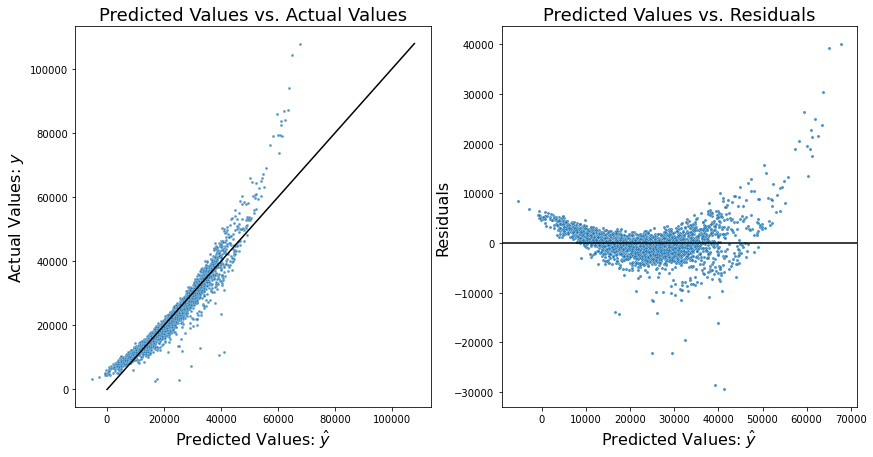

In [96]:
plot_results(final_df['bill_amount'], preds, residuals)

Using a standard OLS model on the full dataset, we notice that there is a clear non-linearity of predictions when compared to the actual y values. Additionally, there is clear heteroscedasticity as the residuals seem to have a pattern (increasing below 20000 and above 30000). These violate the LINE assumptions involved in MLR, which affects the reliability of our model. In order to deal with these issues, we can log transform the target variable.

### Model with Log Transformed Target Variable

In [97]:
# Creating formula for OLS model, C indicates categorical variable
formula2 = 'np.log(bill_amount) ~ C(medical_history_1) + C(medical_history_2) + C(medical_history_3) + \
            C(medical_history_4) + C(medical_history_5) + C(medical_history_6) + \
            C(medical_history_7) + total_med_hist + C(symptom_1) + C(symptom_2) + \
            C(symptom_3) + C(symptom_4) + C(symptom_5) + total_symptoms + weight + \
            C(gender) + C(race) + C(resident_status) + age_admitted'

In [98]:
model2 = smf.ols(formula=formula2, data=final_df)

In [99]:
res2 = model2.fit()

#### Analysing Predictions

In [100]:
preds2 = res2.predict(final_df.drop(columns='bill_amount'))
residuals2 = final_df['bill_amount'] - np.exp(preds2)

In [101]:
mean_squared_error(final_df['bill_amount'], np.exp(preds2), squared=False)

2236.5576104182114

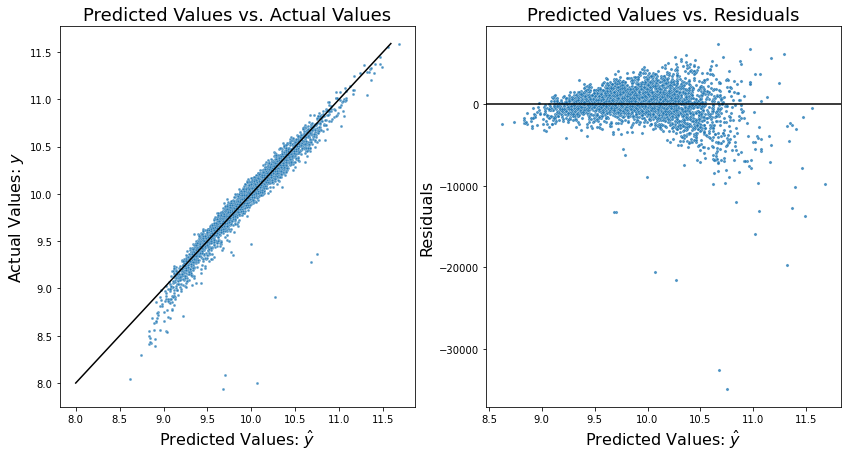

In [102]:
plot_results(np.log(final_df['bill_amount']), preds2, residuals2, origin=8)

Here, we can see that the predictions vs actual values exhibit a much more linear relationship. The heteroscedasticity of residuals have also decreased, although there is still some (greater variance of residuals as $\hat{y}$ increases).

The RMSE of the model also improved by almost 30% (3180.9 -> 2236.6), indicating that the model is performing much better at predicting the final bill amount.

### Model Analysis

In [103]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(bill_amount)   R-squared:                       0.941
Model:                             OLS   Adj. R-squared:                  0.941
Method:                  Least Squares   F-statistic:                     2708.
Date:                 Mon, 30 Aug 2021   Prob (F-statistic):               0.00
Time:                         20:16:34   Log-Likelihood:                 2700.6
No. Observations:                 3400   AIC:                            -5359.
Df Residuals:                     3379   BIC:                            -5230.
Df Model:                           20                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     8.6319      0.019    453.847      0.000       8.595       8.669
C(medical_history_1)[T.1]     0.2018      0.005     42.397      0.000       0.193       0.211
C(medical_history_2)[T.1]    -0.0575      0.004    -13.810      0.000      -0.066      -0.049
C(medical_history_3)[T.1]    -0.0364      0.005     -7.077      0.000      -0.047      -0.026
C(medical_history_4)[T.1]    -0.0781      0.008    -10.270      0.000      -0.093      -0.063
C(medical_history_5)[T.1]    -0.0132      0.007     -1.825      0.068      -0.027       0.001
C(medical_history_6)[T.1]     0.0924      0.004     21.922      0.000       0.084       0.101
C(medical_history_7)[T.1]    -0.0340      0.004     -8.058      0.000      -0.042      -0.026
C(symptom_1)[T.1]            -0.0548      0.004    -15.550      0.000      -0.062      -0.048
C(symptom_2)[T.1]            -0.0143      0.004     -4.052      0.000      -0.021      -0.007
C(symptom_3)[T.1]            -0.0008      0.003     -0.221      0.825      -0.007       0.006
C(symptom_4)[T.1]            -0.0323      0.004     -8.627      0.000      -0.040      -0.025
C(symptom_5)[T.1]             0.3033      0.003     88.044      0.000       0.297       0.310
C(gender)[T.Male]            -0.0085      0.004     -2.077      0.038      -0.017      -0.000
C(race)[T.Indian]             0.1966      0.006     30.788      0.000       0.184       0.209
C(race)[T.Malay]              0.4451      0.005     93.570      0.000       0.436       0.454
C(race)[T.Others]             0.0996      0.008     11.756      0.000       0.083       0.116
C(resident_status)[T.PR]     -0.5107      0.010    -51.436      0.000      -0.530      -0.491
C(resident_status)[T.SC]     -0.6952      0.009    -77.829      0.000      -0.713      -0.678
total_med_hist                0.0750      0.002     38.054      0.000       0.071       0.079
total_symptoms                0.2012      0.001    136.217      0.000       0.198       0.204
weight                        0.0063      0.000     34.024      0.000       0.006       0.007
age_admitted                  0.0094      0.000     73.287      0.000       0.009       0.010
==============================================================================
Omnibus:                     4251.970   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1259160.482
Skew:                          -6.472   Prob(JB):                         0.00
Kurtosis:                      96.384   Cond. No.                     1.35e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.72e-27. This might in

We can gain some insights from the summary results above:

**R-squared**

R-squared is the measurement of how much of the target variable (`bill_amount`) is explained by changes in our dependent variables. Our model has a R-squared value of 0.941, which means that it is able to explain 94.1% of the change in the `bill_amount`.

**Adjusted R-squared**

R-squared has the issue that its value will not decrease when we add more variables, so it does not reflect whether more 'useful' variables are added or not. Adjusted R-squared deals with this by penalising the formula based on the number of variables. Our model has an adjusted R-squared value of 0.941, indicating that almost all the variables are contributing properly.

**Prob(F-statistic)**

This value tells us the likelihood that the group of variables has no effect on the target. Our model has a value of 0, indicating that at least one of the dependent variables has a significant effect on the target variable.

**P > |t|**

These values represent how likely the coefficient of the individual predictor is measured through the model by chance. Given an $\alpha$ value of 0.05, `medical_history_5` and `symptom_3` can be considered as statistically insignificant predictors.

#### Coefficients

The coefficient values represent how much a unit change in that individual variable will affect the independent variable. For instance, a 1 unit change in `weight` would result in a 0.0063 unit change in the target, which in this case is the *log transformed* `bill_amount`.

The precise equation for our model would be:

$$\log(y) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

However, $\log(y)$ does not make much sense. We will need to exponentiate the equation to have useful results:

$$y = e^{\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p}$$

In effect, a 1 unit change in `weight` would result in a $e^{0.0063}$ = **1.0063** times increase in the `bill_amount` when compared to the baseline.

**Baseline**

The baseline for our model is the `bill_amount` when all other coefficients are set to 0:

$$y = e^{\beta_0}$$

For categorical variables (`gender`, `race`, `resident_status`), the baseline represents the reference value which is not included in the model. In other words, the baseline expected value for our model ($e^{8.631918}$ = **$5607.82**) is for the following hypothetical case:

> A female Chinese foreigner patient with no medical history, no symptoms and a hypothetical weight and age of 0

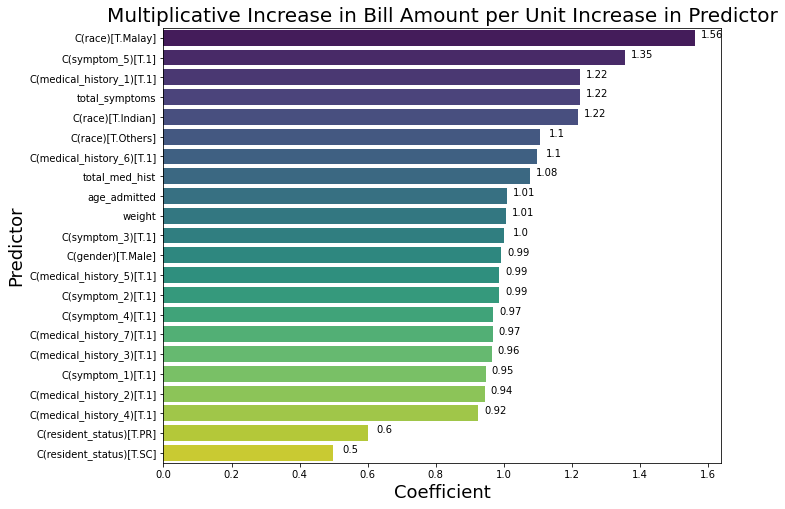

In [104]:
# Visualising importance of individual predictors
feature_names = np.array(np.exp(res2.params).drop(index='Intercept').sort_values(ascending=False).index)
feature_coefs = np.array(np.exp(res2.params).drop(index='Intercept').sort_values(ascending=False))

# Create dataframe with predictors
data={'feature_names':feature_names, 'feature_coefs':feature_coefs}
feature_df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10,8))
ax = sns.barplot(x=feature_df['feature_coefs'], y=feature_df['feature_names'], palette='viridis')
for index, row in enumerate(feature_coefs):
    ax.text(row + 0.05, index, round(row, 2), color='black', ha="center")
    
plt.title('Multiplicative Increase in Bill Amount per Unit Increase in Predictor', fontsize=20)
plt.xlabel('Coefficient', fontsize=18)
plt.ylabel('Predictor', fontsize=18);

From the chart, we can draw some conclusions:

- `race` is an important predictor. If the patient is not Chinese, the final bill amount tends to be higher. All else being equal, Malay patients have bill amounts which are 56% higher!
- If a patient has `symptom_5`, `medical_history_1` or `medical_history_6`, the final bill amount tends to be higher as well
- `resident_status` is also an important predictor. Singapore Citizens and PRs have much lower bill amounts than foreigners
- A patient's `gender`, `age` and `weight` have barely any effect on the predicted bill amount
- `medical_history_5` and `symptom_3`, which were found to be statistically insignificant, also have barely any effect on the predicted bill amount.
- Most of the other individual symptoms and medical histories have a slight negative relationship with the bill amount. However, this is balanced by the `total_med_hist` and `total_symptoms`, which have a greater positive effect on the target.

## Conclusion

The MLR model built performs quite well in predicting the log of `bill_amount`, with an adjusted R-square score of 0.941 and a RMSE of 2236.6. 17 of the 19 predictors were found to be significant, with `race`, `resident_status`, `total_med_hist` and `total_symptoms` having greater effects on the predicted bill amount. This is in line with the EDA performed on the mentioned features.

### Recommendations

In order to tackle the problem of high hospitalisation bills for this particular condition, some recommendations can be drawn from the analysis of the data given:

#### Conduct further studies into race-specific differences

Although we mentioned that exploring racial differences was not the focus of this project, the results indicate that `race` plays a big role in a patient's cost of care. Malay patients were predicted to have 56% higher bills than Chinese patients, while the value for Indian and Others patients were 22% and 10% respectively. These are not insignificant numbers and further studies should be conducted to look into the underlying cause, be it social, cultural or other aspects related to race. Targeted measures can then be developed to tackle these underlying causes and equalise the cost of care for all races.

#### Target `symptom_5`, `medical_history_1` & `medical_history_6` for early intervention

A [study by the British Medical Association](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwivye721djyAhWRXisKHTrwCB4QFnoECBoQAQ&url=http%3A%2F%2Fsentpressrelease.com%2Fpressrelease%2Fattachment%2F73108%2F79fbe4f4-c323-4f1e-a7df-9abe85930d12%2F90d6fdbe-bd30-4f4b-8557-9250948a642c%3FfileDisplayName%3DExploring%2520the%2520cost%2520of%2520early%2520intervention.pdf&usg=AOvVaw0mokqOBV381ha6EGn-vBpC) has shown that early intervention and preventions were largely cost effective and cost saving. Mass-media campaigns can be formulated specifically targeting these 3 features as they were found to have the greatest effect on a patient's cost of care. When the patients are admitted to the hospital with these symptoms/history, it is already too late and they would likely lead to higher bills. However, lowering the general occurrences of these in the public would definitely improve the overall cost of care for this condition.

### Limitations

Given the anonymised datasets, there are definitely some limitations that restrict the effectiveness of understanding the problem.

#### Ambiguity of bills

As explored earlier, each patient had multiple bills per hospitalisation. More details about the bills including the billing department and breakdown of bill amounts would definitely help us understand the problem better. 

Furthermore, there are no details whether the bills are nett or gross amounts (considering government subsidies, insurance payouts, etc). Although our analysis found that `resident_status` is a very important factor in the final bill amount, it is difficult to assess how useful the feature is in resolving our problem statement without the additional information mentioned.

#### Lack of context in understanding data collection

Features such as `medical_history` and `symptoms` are difficult to understand without knowing how the data is collected. Symptoms and medical history are usually determined by the doctor or nurse, either through questioning or physical examination. [Studies have shown](https://www.researchgate.net/publication/7757279_Physician_Responses_to_Ambiguous_Patient_Symptoms) that doctors ignore ambiguous symptoms quite often, and this can lead to inconsistencies in the data (as discovered earlier, with patients having different medical histories for each hospitalisation).

#### Addressing anonymity

Understandably, anonymity and ambiguity comes with working with healthcare data. Although we usually cannot control the amount of information we have about the data given to us (especially in Singapore), gaining deeper domain knowledge can help us come up with reasonable assumptions given the data we have. Working with these assumptions can definitely help us understand the problem better.